Read CSV
Generate Table with headings
Generate y_train data
    Read Steering Angle
Generate X_train data
    Read images (center, left, right) using filename
    Crop
    Augment
        Flip,resize - append(y_train, offset)
        Noise, resize - append(y_train, offset)
        blur, resize - append(y_train, offset)

Neural Network Implmentation
training, validation, testing split
Generator Function

Neural Network Training
Save Model

    

In [1]:
## Learning: Important to cast to float. For example: float(line[3])
## Learning: left_angle = float(batch_sample[3])+steering_ang_correction .. for left image we add not subtract!!!
## since it is a correction


### TUNING PARAMETERS

In [1]:
# Steering Angle Offset
# Note: Steering Angle is normalized to -1 and 1
steering_ang_correction = 2
zero_angle_keep = 0.8

### Read CSV

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
csv_headers = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

data = pd.read_csv('CarSim_data/driving_log.csv', names=csv_headers)

### Create Features and Labels

In [4]:
def i_crop(I):
    return I[55:135,:]

def i_resize(I):
    return cv2.resize(I,(64, 64),interpolation=cv2.INTER_AREA)

def i_flip(I, steering):
    return cv2.flip(I,1), -steering
    
def i_bright(I):
    I = cv2.cvtColor(I, cv2.COLOR_RGB2HSV)
    I[:,:,2] = I[:,:,2]+(np.random.uniform(-20,20))
    return cv2.cvtColor(I, cv2.COLOR_HSV2RGB)    

### Image Procesing Playground

In [5]:
# II = cv2.imread('./CarSim_data/IMG/left_2017_03_07_10_23_30_722.jpg')
# plt.imshow(II)

### Generator

In [6]:
import sklearn
import pandas
from sklearn.utils import shuffle
import csv

In [8]:
samples = []
hist_angle = []
with open('./CarSim_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if float(line[3]) == 0:
            if np.random.random() < zero_angle_keep:
                hist_angle.append(float(line[3]))
                samples.append(line)
        else:
            hist_angle.append(float(line[3]))
            samples.append(line)

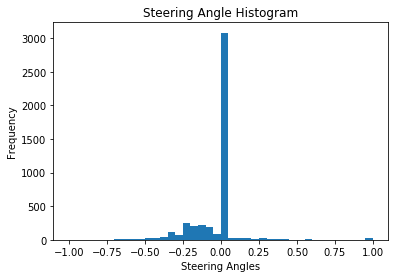

In [9]:
plt.hist(hist_angle, bins = 40);
plt.xlabel('Steering Angles')
plt.ylabel('Frequency')
plt.title('Steering Angle Histogram')

In [10]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [11]:
print(len(train_samples))

3654


## Keras Model

In [12]:
from keras.models import Sequential
from keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten, Lambda, MaxPooling2D
from keras.optimizers import Adam
#from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


In [13]:
# from keras.utils.visualize_util import plot

In [14]:
ch, row, col = 3,64,64

In [15]:
model = Sequential()

model.add(Lambda(lambda x: x/127.5-1., input_shape=(col, row, ch), output_shape=(col, row, ch)))


model.add(Convolution2D(24,5,5, init='glorot_uniform', subsample=(2, 2), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(36,5,5, init='glorot_uniform', subsample=(2, 2), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(48,5,5, init='glorot_uniform', subsample=(2, 2), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(64,3,3, init='glorot_uniform', border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(64,3,3, init='glorot_uniform', border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(1164))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1))

In [16]:
#print(model.summary())

In [17]:
model.compile(loss='mse', optimizer='adam')

In [18]:
def myGenerator(samples, batch_size):
    num_samples = len(samples)
    while 1: # loop forever so generator never terminates
        shuffle(samples)
        # for logging
        batch_num_idx = 1
        for offset in range(0, num_samples, batch_size):
            
            print('Batch Number: ', batch_num_idx, ' End')
            print(' ')
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Center Image ===================
                name = batch_sample[0].strip()
                center_image = i_resize(i_crop(cv2.imread(name)))
                center_angle = float(batch_sample[3])               
                images.append(center_image)
                angles.append(center_angle)
                
                center_image, center_angle = i_flip(center_image, center_angle)                
                images.append(center_image)
                angles.append(center_angle)
                
            
            
                # Left Image =====================
                name = batch_sample[1].strip()
                left_image = i_resize(i_crop(cv2.imread(name)))
                left_angle = float(batch_sample[3])+steering_ang_correction
                images.append(left_image)
                angles.append(left_angle)
                
                left_image, left_angle = i_flip(left_image, left_angle)                
                images.append(left_image)
                angles.append(left_angle)
                
                # Right Image
                name = batch_sample[2].strip()
                right_image = i_resize(i_crop(cv2.imread(name)))
                right_angle = float(batch_sample[3])-steering_ang_correction
                images.append(right_image)
                angles.append(right_angle)
                
                right_image, right_angle = i_flip(right_image, right_angle)                
                images.append(right_image)
                angles.append(right_angle)
                
                         
            X_train = np.array(images)
            print('X_train Shape')
            print(X_train.shape)
            print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
            print(' ')
            y_train = np.array(angles)
            
            # for logging
            batch_num_idx = batch_num_idx+1
            
            yield shuffle(X_train, y_train)

In [19]:
# compile and train the model using generator function
train_generator = myGenerator(train_samples, batch_size=256)
validation_generator = myGenerator(validation_samples, batch_size=256)

In [20]:
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5)

Epoch 1/5Batch Number: 
 1  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  2  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  3  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  4  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  5  End
 
3072/3654 [========================>.....] - ETA: 0s - loss: 2.7061X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  6  End
 
Batch Number:  1  End
 


/home/anuj/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  7  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  2  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  8  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
4608/3654 [=====================================] - 4s - loss: 2.6995 - val_loss: 2.6887
Epoch 2/5
1536/3654 [===========>..................] - ETA: 0s - loss: 2.7048X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  9  End
 
3072/3654 [========================>.....] - ETA: 0s - loss: 2.7024Batch Number:  3  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  10  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Batch Number:  4  End
 
X_train Shape
(1536, 64, 64, 3)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

### Save Model

In [21]:
import json

model_json = model.to_json()
with open ('model.json', 'w') as f:
    json.dump(model_json, f, indent=4, sort_keys=True, separators=(',', ':'))
    
# model.save_weights will only save the weights
model.save('model.h5')
print("Model Saved")

Model Saved
